## **REQUIRED LIBRARIES**

In [1]:
# the specified libraries versions should be used to avoid any errors
!pip install keras==2.2.5
%tensorflow_version 1.x
!pip install h5py==2.10.0

     |████████████████████████████████| 337kB 7.6MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
TensorFlow 1.x selected.
     |████████████████████████████████| 2.9MB 7.7MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


## **Mounting google drive to import mrcnn model and dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Using pre-trained model weights from mrcnn model

In [3]:
import os
import shutil
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN-ANT/") # The directory location for MRCNN-ANT model folder

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # It is required to use local version of mrcnn model available in MRCNN-ANT folder to avoid training errors.

from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
from mrcnn.config import Config
from mrcnn import model as modellib, utils


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


class AntConfig(Config):
    """Configuration for training on the ant  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Ant"

    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + Ant

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


Using TensorFlow backend.


## Setting up the AntDataset class

In [4]:
class AntDataset(utils.Dataset):

    def load_Ant(self, dataset_dir, subset):
        """Load a subset of the ant dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "Ant")
        # self.add_class("object", 2, "Man")
        # self.add_class("object", 3, "xyz")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "ant_detect_json.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            #print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Ant": 1,}#,"Man": 2} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Ant dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
          rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
          mask[rr, cc, i] = 1
           
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## **Defining and configuring the training model**

In [5]:
def train(model):
    """Train the model."""
    # Training dataset
    dataset_train = AntDataset()
    dataset_train.load_Ant("/content/drive/MyDrive/MaskRCNN-ANT/Dataset", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = AntDataset()
    dataset_val.load_Ant("/content/drive/MyDrive/MaskRCNN-ANT/Dataset", "val")
    dataset_val.prepare()
    
                                                          
    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5, # define the epoch value upon how many times you want to serve the dataset to model for learning features
                layers='heads') #If you want you can set ‘layers’ to ‘all’ for training all the layers in the model.

config = AntConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)


weights_path = COCO_WEIGHTS_PATH 
print("Loading weights ", weights_path)
    # Download weights file
if not os.path.exists(weights_path): 
  utils.download_trained_weights(weights_path)


model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Loading weights  /content/drive/MyDrive/MaskRCNN-ANT/mask_rcnn_coco.h5


# **TRAIN MODEL** (Only run this cell if you want to train the model)

In [ ]:
# !pip install keras==2.2.5
# use above code if you see the different keras version and getting error
# if error occurs restart runtime or again run the above keras command
train(model)

## Export the model weights trained for ant dataset to specific folder for testing the model **(Not needed unless the model is trained again)**

In [ ]:
shutil.copytree('/content/Mask_RCNN/mrcnn/logs', '/content/drive/MyDrive/Ant Logs') 
#This is to separate the ant model weights to another folder. 
#In testing part, it is required to change the path for model weights if new weights have been exported by training the model again.

# **TESTING**

In [8]:
import os
import sys
import random
import math
import re
import time
import cv2
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
from PIL import Image




# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN-ANT/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap, compute_recall
from mrcnn import utils

from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights
#Look for the path where you exported the trained weights for ant dataset.
WEIGHTS_PATH = "/content/drive/MyDrive/MaskRCNN-ANT/AntLogs/object20210512T0216/mask_rcnn_object_0005.h5" 


config = AntConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/content/drive/MyDrive/MaskRCNN-ANT/Dataset")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [9]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Loading ant dataset for testing

In [12]:
CUSTOM_DIR = "/content/drive/MyDrive/MaskRCNN-ANT/Dataset"

#Load train dataset
dataset_train = AntDataset()
dataset_train.load_Ant(CUSTOM_DIR, "train")

# Must call before using the dataset
dataset_train.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))


# Load validation dataset
dataset_val = AntDataset()
dataset_val.load_Ant(CUSTOM_DIR, "val")

# Must call before using the dataset
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))


#Load video frame pictures to check model predictions
video_frame_dataset=  "/content/drive/MyDrive/MaskRCNN-ANT/Dataset/video_frames"

list_test = os.listdir(video_frame_dataset) # dir is your directory path
number_files = len(list_test)
print("Video frame Images",number_files)

objects: ['Ant', 'Ant']
numids [1, 1]
objects: ['Ant', 'Ant']
numids [1, 1]
objects: ['Ant', 'Ant', 'Ant']
numids [1, 1, 1]
objects: ['Ant']
numids [1]
objects: ['Ant', 'Ant']
numids [1, 1]
objects: ['Ant', 'Ant']
numids [1, 1]
objects: ['Ant']
numids [1]
objects: ['Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['Ant']
numids [1]
objects: ['Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant', 'Ant']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['Ant', 'Ant', 'Ant', 'Ant']
numids

## Loading model and ant weights

In [13]:
#LOAD MODEL
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    
# Load ANT weights, Or load the last model weights you trained
weights_path = WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/MyDrive/MaskRCNN-ANT/AntLogs/object20210512T0216/mask_rcnn_object_0005.h5
Re-starting from epoch 5


## ANT DETECTION ON TRAINING DATASET

7
image ID: object.20210507_101049.jpg (7) /content/drive/MyDrive/MaskRCNN-ANT/Dataset/train/20210507_101049.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


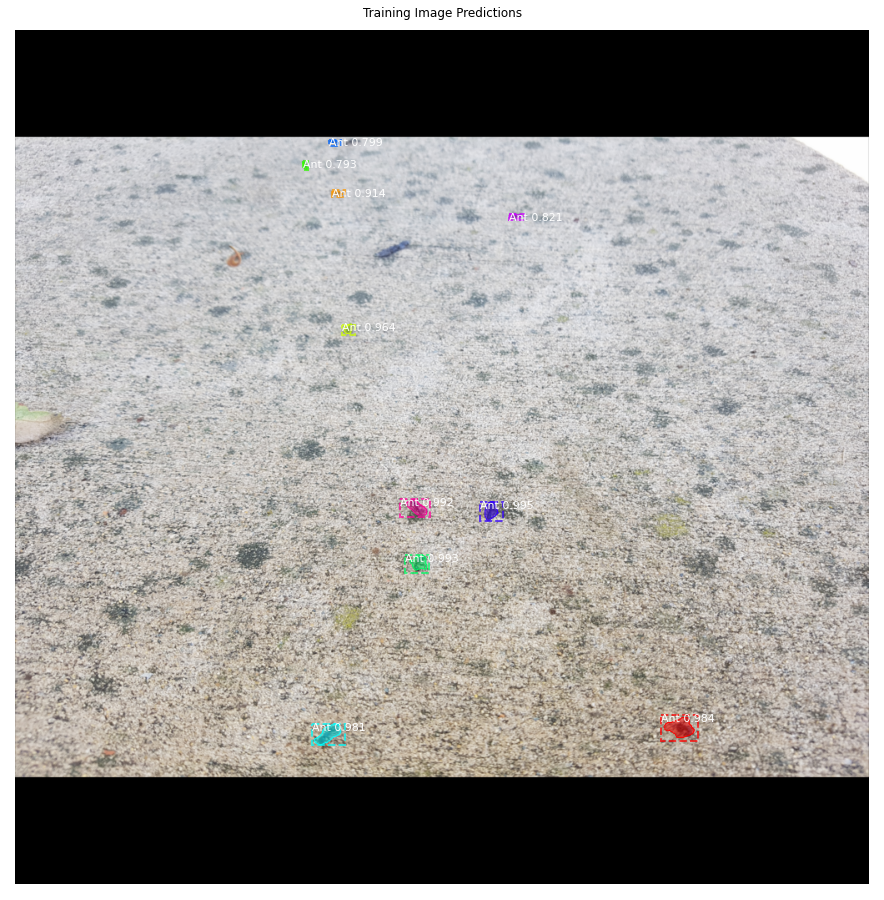

In [19]:
#RUN DETECTION FOR TRAINING DATASET
image_id = random.choice(dataset_train.image_ids)
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
info = dataset_train.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                      dataset_train.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=ax,
                            title="Training Image Predictions")

## ANT DETECTION ON VALIDATION IMAGE

6
image ID: object.20210507_101835.jpg (6) /content/drive/MyDrive/MaskRCNN-ANT/Dataset/val/20210507_101835.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  375.00000  max:  720.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


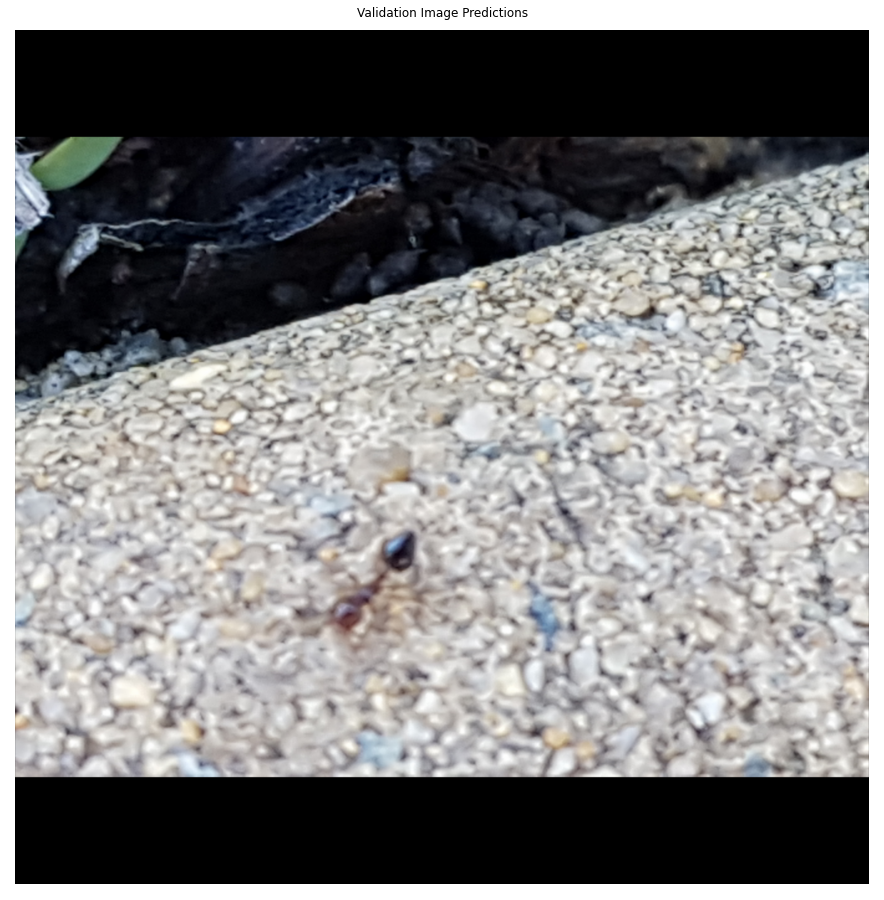

In [32]:
#RUN DETECTION FOR VALIDATION DATASET
image_id = random.choice(dataset_val.image_ids)
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                      dataset_val.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Validation Image Predictions")
    
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Average Precision, Average recall, PR graph and GROUND TRUTH for the validation image

Average Precision for Validation image 0.10000000149011612
Average Recall for Validation image 0.2
F1 score for the validation image 0.3175257739623936


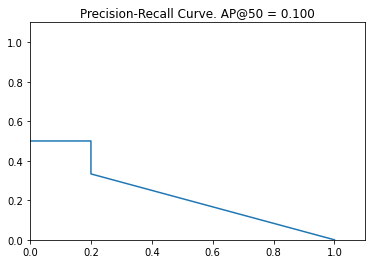

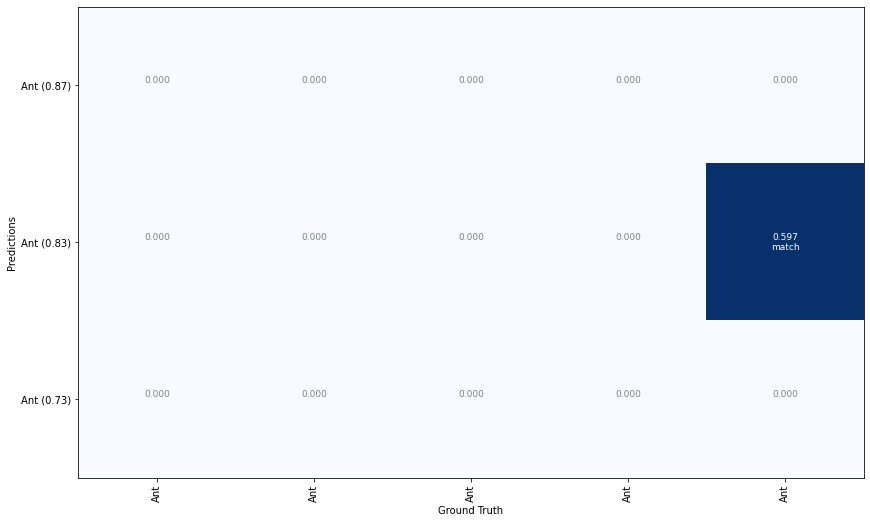

In [27]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])

AR, positive_ids = compute_recall(r["rois"], gt_bbox, iou=0.5)
visualize.plot_precision_recall(AP, precisions, recalls)

F1_scores=(2* (mean(precisions) * mean(recalls)))/(mean(precisions) + mean(recalls))
print("Average Precision for Validation image",AP)
print("Average Recall for Validation image",AR)
print("F1 score for the validation image",F1_scores)
# Display ground truth and predicted grid
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

**Model prediction for specific jpeg image (Insert the path for specific image in the code below)**

1
Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


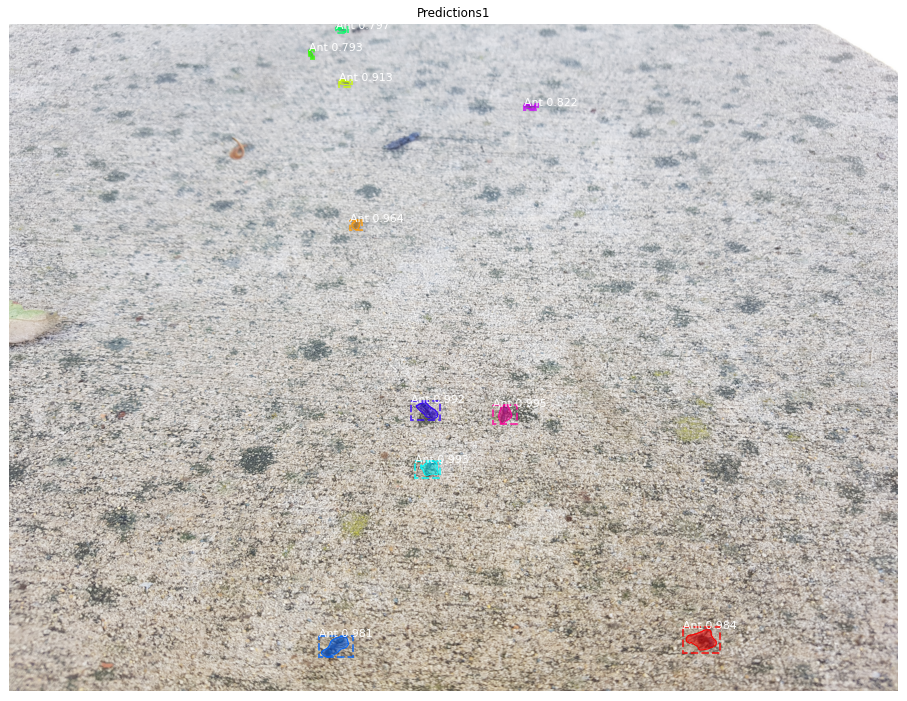

In [42]:
test_image1 = mpimg.imread('/content/drive/MyDrive/MaskRCNN-ANT/Dataset/train/20210507_101049.jpg')

# Run object detection
print(len([test_image1]))
results1 = model.detect([test_image1], verbose=1)
# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(test_image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset_train.class_names, r1['scores'], ax=ax, title="Predictions1")

## **MODEL EVAULATION FOR TRAINING AND VALIDATION DATASET: MEAN AP, MEAN AR, MEAN F1 SCORE**

In [23]:
# calculate the mAP,mAR and F1 score for a model on a given dataset
def evaluate_model(dataset, model, config):
  APs = list();
  ARs = list();
  for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, config, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
    scaled_image = mold_image(image, config)
		# convert image into one sample
    sample = expand_dims(scaled_image, 0)
		# make prediction
    yhat = model.detect(sample, verbose=0)
		# extract results for first sample
    r = yhat[0]
		# calculate statistics, including AP
    AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    AR, positive_ids = compute_recall(r["rois"], gt_bbox, iou=0.5)

    APs.append(AP)
    ARs.append(AR)
	# calculate the mean AP across all images
  mAP = mean(APs)
  mAR = mean(ARs)
  F1_score_2 = (2 * mAP * mAR)/(mAP + mAR)
  return mAP, mAR, F1_score_2

In [24]:
# evaluate model on training dataset
train_mAP,train_mAR, train_F1_score = evaluate_model(dataset_train, model, config)
print("Train mAP: %.3f" % train_mAP)
print("Train mAR: %.3f" % train_mAR)
print("Train F1-score: %.3f" % train_F1_score)
# evaluate model on validation dataset
val_mAP,val_mAR,val_F1_score = evaluate_model(dataset_val, model, config)
print("Validation mAP: %.3f" % val_mAP)
print("Validation mAR: %.3f" % val_mAR)
print("Validation F1-score: %.3f" % val_F1_score)

Train mAP: 0.338
Train mAR: 0.959
Train F1-score: 0.500
Validation mAP: 0.318
Validation mAR: 0.794
Validation F1-score: 0.454


### Model predcitions for the video frames taken by screeshots

In [25]:
# This is for predicting images which are taken as screeshots from video sequence 


dataset_test = '/content/drive/MyDrive/MaskRCNN-ANT/Dataset/video_frames'
onlyfiles = [ f for f in listdir(dataset_test) if isfile(join(dataset_test,f)) ]
images = np.empty(len(onlyfiles), dtype=object)


for n in range(0, len(onlyfiles)):
    
    images[n] = cv2.imread( join(dataset_test,onlyfiles[n]) )
    results1 = model.detect([images[n]], verbose=1)

    ax=get_ax(1)
    # Visualize results
    r1 = results1[0]
    visualize.display_instances(images[n], r1['rois'], r1['masks'], r1['class_ids'], 
                            dataset_val.class_names, r1['scores'], ax=ax,
                            title="Test Image Prediction")

Output hidden; open in https://colab.research.google.com to view.

### Model prediction for different image types such as PNG, JPEG

1
Processing 1 images
image                    shape: (725, 967, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


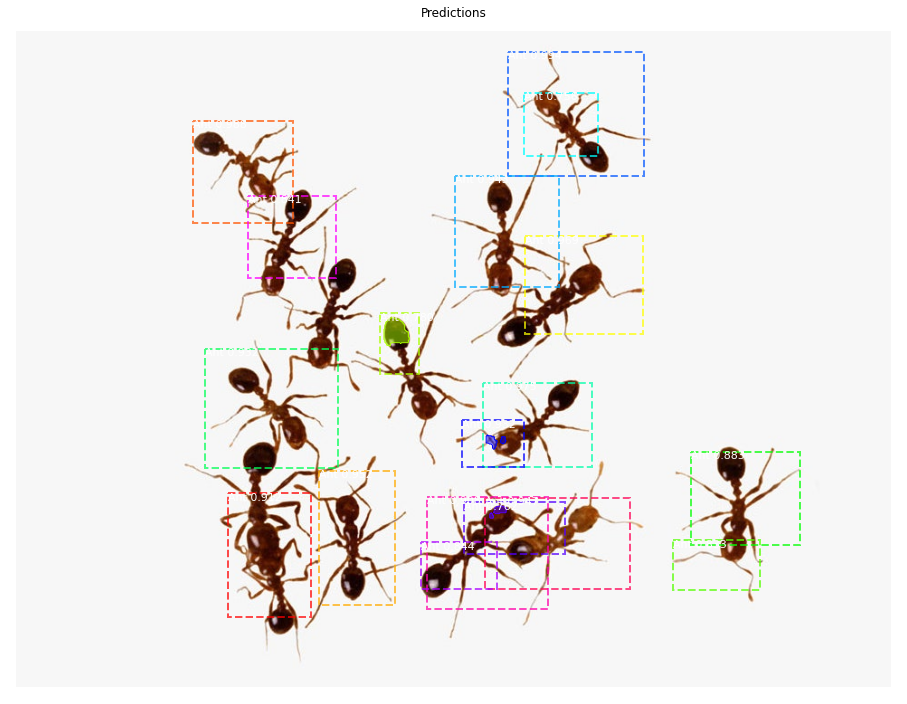

In [82]:
image_test = Image.open("/content/drive/MyDrive/fireants-pngtest.png")

if image_test.mode == 'P':
  image_test=im.convert('RGB')


image_test = np.array(image_test) 
  
print(len([image_test]))
results1 = model.detect([image_test], verbose=1)
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image_test, r1['rois'], r1['masks'], r1['class_ids'],
                              dataset_val.class_names, r1['scores'], ax=ax, title="Predictions")

